In [27]:
import sys
sys.path.append('/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github')


In [ ]:

# import pysparnn.cluster_index as ci
# import scipy.sparse
# import os
# import math
import numpy as np
import pandas as pd
import random
import math
from re_sample.utils import train_test_split, df_to_matrix ,matrix_to_df_2, threshold_interactions_df, matrix_to_df,set_intersection,get_0_and_p_index,set_diff, matrix_to_full_df

!pip install surprise
from surprise import Reader, accuracy
from surprise import SVD
from surprise import Dataset
from collections import Counter
from collections import defaultdict

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt

from pct.tree.heuristic.Heuristic import Heuristic5
from pct.tree.heuristic.NumericHeuristic_movie import NumericHeuristic5
from pct.tree.splitter.splitter import Splitter
from pct.tree.tree_movie import Tree
import scipy.sparse as sp


[notice] A new release of pip is available: 23.2.1 -> 25.1.1
[notice] To update, run: pip install --upgrade pip


In [ ]:
data = pd.read_csv("/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/ml-1m/ratings.txt",sep='::',index_col=False,names=["user_id","item_id","rating","timestamp"],header=None,engine='python')
my_seed = 7
np.random.seed(my_seed)
# Iteratively filters out users and items with fewer than the threshold number of interactions until no changes happen.
data = threshold_interactions_df(data,'user_id','item_id',100,100)

Starting interactions info
Number of rows: 6040
Number of cols: 3706
Sparsity: 4.468%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%


In [30]:
data = threshold_interactions_df(data,'user_id','item_id',100,100)


Starting interactions info
Number of rows: 2828
Number of cols: 1919
Sparsity: 14.284%
Ending interactions info
Number of rows: 2828
Number of columns: 1919
Sparsity: 14.284%


In [31]:
all_user_ids = sorted(data['user_id'].unique())
warm_users = all_user_ids[:1414]
cold_users = all_user_ids[1414:]


df_warm = data[data['user_id'].isin(warm_users)].copy()
df_cold = data[data['user_id'].isin(cold_users)].copy()

In [32]:
matrix_warm, rid_to_idx_warm, idx_to_rid_warm, cid_to_idx, idx_to_cid = df_to_matrix(
    df_warm, "user_id", "item_id", "rating"
)


matrix_cold, rid_to_idx_cold, idx_to_rid_cold, _, _ = df_to_matrix(
    df_cold, "user_id", "item_id", "rating"
)

In [33]:
al, train_cold_K, _ = train_test_split(matrix_cold, 1)


X_cold, test_cold, _ = train_test_split(al, 30)

In [39]:
def elicitation_by_tree_path_retrain_depth_warm(
    tree_model_class,
    train,              # lil_matrix: cold users' known ratings (1 item/user, updated over rounds)
    test,               # lil_matrix: cold users' test ratings (30 ratings/user), fixed
    X,                  # lil_matrix: cold users' "hidden" ratings, revealed 1 per round
    matrix_warm,        # lil_matrix: warm users' full ratings
    idx_to_rid_cold,    # cold user index → user_id
    idx_to_rid_warm,    # warm user index → user_id
    idx_to_cid,         # item index → item_id
    iteration=5
):
    """
    Method 2: Retrain tree each round using warm + cold user data.
    Walk i steps for each cold user to reach a node and elicit a new rating.

    Returns:
    - rmse_list: RMSE after each iteration
    - mae_list: MAE after each iteration
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}

    # Step 0: Baseline SVD using only cold-start (1 rating per user)
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    algo = SVD()
    trainset = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
    algo.fit(trainset)

    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (Tree depth = {i+1})")

        # Step 1: Prepare tree training data (warm + updated cold)
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, cold_df], ignore_index=False)

        tree_model = tree_model_class(max_depth=i+1, min_instances=5)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        # Step 2: Walk tree and elicit a new rating for each cold user
        for u in range(num_users):
            node = tree_model.root
            depth = 0

            while node and not node.is_leaf and node.attribute_name and depth < i:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break
                item_idx = cid_to_idx[item]
                rating = train_copy[u, item_idx]

                if rating >= 4:
                    node = node.children[0]  # Lovers
                elif rating > 0:
                    node = node.children[1]  # Haters
                else:
                    node = node.children[2]  # Unknowns

                depth += 1

            if node is None or node.attribute_name is None:
                continue

            item = node.attribute_name
            if item not in cid_to_idx:
                continue
            item_idx = cid_to_idx[item]
            rating = X_copy[u, item_idx]

            if rating > 0:
                train_copy[u, item_idx] = rating
                X_copy[u, item_idx] = 0

        # Step 3: Evaluate updated cold user SVD model
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        algo = SVD()
        trainset = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset()
        algo.fit(trainset)

        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        testset = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader).build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list


In [34]:
from collections import defaultdict


def elicitation_by_tree_path_retrain_skiped_warm(tree_model_class, train, test, X, matrix_warm, idx_to_rid_cold, idx_to_rid_warm, idx_to_cid, iteration=5):
    """
    Method 3 (revised): Retrain tree at each round. For each user, traverse from root down the tree.
    At each level, if the item was already asked (stored in asked_items), go deeper.
    Ask the first item the user hasn't been asked before.

    Parameters:
    - tree_model_class: class of the decision tree model (not instance)
    - train, test, X: lil_matrix (known ratings, test set, and full matrix)
    - idx_to_rid, idx_to_cid: index-to-ID mapping
    - iteration: number of elicitation rounds

    Returns:
    - rmse_list, mae_list
    """

    num_users, num_items = train.shape
    train_copy = train.tolil().copy()
    X_copy = X.tolil().copy()
    rmse_list, mae_list = [], []
    cid_to_idx = {v: k for k, v in idx_to_cid.items()}
    asked_items = {u: set() for u in range(num_users)}  

    # Step 0: Baseline evaluation
    print("🔍 Evaluating baseline RMSE/MAE...")
    train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    trainset = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(trainset)
    test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
    test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    testset = test_data.build_full_trainset().build_testset()
    predictions = algo.test(testset)
    rmse_list.append(accuracy.rmse(predictions, verbose=True))
    mae_list.append(accuracy.mae(predictions, verbose=True))
    print("✅ Baseline evaluation complete.")

    for i in range(iteration):
        print(f"\n🔁 Iteration {i+1}/{iteration} (skip asked items, walk from root)")

        # Retrain tree using current train_copy
        tree_model = tree_model_class(max_depth=i + 1, min_instances=5)
        warm_df = matrix_to_full_df(matrix_warm, idx_to_rid_warm, idx_to_cid)
        cold_df = matrix_to_full_df(train_copy, idx_to_rid_cold, idx_to_cid)
        x_df = pd.concat([warm_df, cold_df], ignore_index=False)
        tree_model.fit(x_df, x_df)
        print("🌳 Tree re-trained.")

        for u in range(num_users):
            node = tree_model.root

            # Traverse down the tree until we find an unasked item
            while node and not node.is_leaf and node.attribute_name:
                item = node.attribute_name
                if item not in cid_to_idx:
                    node = None
                    break

                item_idx = cid_to_idx[item]

                if item_idx in asked_items[u]:
                    # Already asked, go deeper based on user's rating
                    rating = train_copy[u, item_idx]
                    if rating >= 4:
                        node = node.children[0]
                    elif rating > 0:
                        node = node.children[1]
                    else:
                        node = node.children[2]
                    continue

                # First unasked item: try to add it to training
                asked_items[u].add(item_idx)  
                rating = X_copy[u, item_idx]
                if rating > 0:
                    train_copy[u, item_idx] = rating
                    X_copy[u, item_idx] = 0
                break  # only ask one item per user per iteration

        # Step 3: Evaluate with SVD
        print("📊 Evaluating after this iteration...")
        train_df = matrix_to_df_2(train_copy, idx_to_rid_cold, idx_to_cid)
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        trainset = data_r.build_full_trainset()
        algo.fit(trainset)
        test_df = matrix_to_df_2(test, idx_to_rid_cold, idx_to_cid)
        test_data = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        testset = test_data.build_full_trainset().build_testset()
        predictions = algo.test(testset)
        rmse_list.append(accuracy.rmse(predictions, verbose=True))
        mae_list.append(accuracy.mae(predictions, verbose=True))
        print(f"✅ Iteration {i+1} complete.")

    return rmse_list, mae_list


In [41]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

pct_2 =elicitation_by_tree_path_retrain_depth_warm(
    tree_model_class=Tree,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=15
)

RMSE: 1.6594
MAE:  1.4539
✅ Baseline evaluation complete.

🔁 Iteration 1/15 (Tree depth = 1)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.5089
MAE:  1.3103
✅ Iteration 1 complete.

🔁 Iteration 2/15 (Tree depth = 2)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.4285
MAE:  1.2305
✅ Iteration 2 complete.

🔁 Iteration 3/15 (Tree depth = 3)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.3976
MAE:  1.1989
✅ Iteration 3 complete.

🔁 Iteration 4/15 (Tree depth = 4)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.3670
MAE:  1.1673
✅ Iteration 4 complete.

🔁 Iteration 5/15 (Tree depth = 5)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.2861
MAE:  1.0835
✅ Iteration 5 complete.

🔁 Iteration 6/15 (Tree depth = 6)
Initializing Splitter.

/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(


✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.2424
MAE:  1.0404
✅ Iteration 7 complete.

🔁 Iteration 8/15 (Tree depth = 8)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.2222
MAE:  1.0208
✅ Iteration 8 complete.

🔁 Iteration 9/15 (Tree depth = 9)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1910
MAE:  0.9912
✅ Iteration 9 complete.

🔁 Iteration 10/15 (Tree depth = 10)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1655
MAE:  0.9690
✅ Iteration 10 complete.

🔁 Iteration 11/15 (Tree depth = 11)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1469
MAE:  0.9524
✅ Iteration 11 complete.

🔁 Iteration 12/15 (Tree depth = 12)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1395
MAE:  0.9464
✅ Iteration 12 complete.

🔁 Iteration 13/15 (Tree depth = 13)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1332
MAE:  0.9410
✅ Iteration 13 complete.

🔁 Iteration 14/15 (Tree depth = 14)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1279
MAE:  0.9365
✅ Iteration 14 complete.

🔁 Iteration 15/15 (Tree depth = 15)
Initializing Splitter...
✅ Calling build()...


/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum(
/Users/camillecu/Downloads/KUL/master_thesis/master_thesis_github/pct/tree/node/node.py:73: RuntimeWarning: invalid value encountered in divide
  prototype /= np.sum

✅ Tree built successfully!
🌳 Tree re-trained.
RMSE: 1.1229
MAE:  0.9318
✅ Iteration 15 complete.


In [35]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
pct_3 =elicitation_by_tree_path_retrain_skiped_warm(
    tree_model_class=Tree,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    matrix_warm=matrix_warm,
    idx_to_rid_cold=idx_to_rid_cold,
    idx_to_rid_warm=idx_to_rid_warm,
    idx_to_cid=idx_to_cid,
    iteration=25
)

🔍 Evaluating baseline RMSE/MAE...
RMSE: 1.6594
MAE:  1.4539
✅ Baseline evaluation complete.

🔁 Iteration 1/25 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 1.5089
MAE:  1.3103
✅ Iteration 1 complete.

🔁 Iteration 2/25 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 1.4285
MAE:  1.2305
✅ Iteration 2 complete.

🔁 Iteration 3/25 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 1.3976
MAE:  1.1989
✅ Iteration 3 complete.

🔁 Iteration 4/25 (skip asked items, walk from root)
Initializing Splitter...
✅ Calling build()...
✅ Tree built successfully!
🌳 Tree re-trained.
📊 Evaluating after this iteration...
RMSE: 1.3670
MAE:  1.1673
✅ It

# NP

In [58]:
def i_variance(matrix):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()

def i_random(matrix):
    c = matrix.copy()
    c_2 = c.power(2)
    E_2 = c_2.mean(0)
    E = c.mean(0)
    v = E_2 - np.sqrt(E)
    return (np.asarray(v)).flatten()
    
def i_entropy(matirx):
    entropy = []
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        len_rating = len(ratings)
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/len_rating)*math.log(count_r[c]/len_rating)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_entropy_0(matirx):
    entropy = []
    c_all = matirx.shape[0]
    for item in range(0, matirx.shape[1]):
        ratings = matirx.getcol(item).data
        count_r = Counter(ratings)
        count_r[0] = c_all - matirx.getcol(item).count_nonzero()
        ent = 0
        for c in count_r:
            ent -= (count_r[c]/c_all)*math.log(count_r[c]/c_all)
        entropy.append(ent)
    return (np.asarray(entropy))

def i_pop(matrix):
    popularity = []
    for item in range(0, matrix.shape[1]):
        popularity.append(matrix.getcol(item).count_nonzero())
        
    return (np.asarray(popularity))

def log_pop_entropy(matrix):
    entropy = i_entropy(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def log_pop_entropy0(matrix):
    entropy = i_entropy_0(matrix)
    popularity = i_pop(matrix)
    scores = np.log(popularity) *  entropy 
    return (np.asarray(scores))

def sqrt_pop_variance(matrix):
    variance = i_variance(matrix)
    popularity = i_pop(matrix)
    scores = np.sqrt(popularity) *  variance 
    return (np.asarray(scores))

def helf(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def helf0(matrix):
    log_U = np.log(matrix.shape[0])
    lf = np.log(i_pop(matrix))/log_U
    h = i_entropy_0(matrix)/np.log(5)
    helf = (2* lf*h)/(lf+h)
    return helf

def i_co_rate(matrix):
    matrix_c = matrix.copy()
    matrix_c[matrix_c != 0] = 1
    c= matrix_c.T.dot(matrix_c)
    c.setdiag(0, k=0)
    
    return np.asarray(c.sum(axis=0))[0]

In [53]:
import scipy.sparse as sp


def elicitation_np_warm(matrix_warm, train,test,X,strategy,iteration,k,positive=False):
    rmse,mae = [],[]
    
    # Performance before elicitation
    train_df = matrix_to_df_2(train,idx_to_rid_cold,idx_to_cid)
    reader = Reader(rating_scale=(1, 5))
    data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
    data_rr = data_r.build_full_trainset()
    algo = SVD()
    algo.fit(data_rr)
    test_df = matrix_to_df_2(test,idx_to_rid_cold,idx_to_cid)
    test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
    test_rr = test_r.build_full_trainset()
    predictions= algo.test(test_rr.build_testset())
    rmse.append(accuracy.rmse(predictions))
    mae.append(accuracy.mae(predictions))
    
    c_u_dict = {}
    all_items = list(range(0,train.shape[1]))
    X_copy = (X.tolil()).copy()
    warm_copy = matrix_warm.tolil().copy()
    train_copy = (train.tolil()).copy()
    

    #scores = strategy(train_copy)
    
    for count in range(0,iteration-1):
        x_matrix = sp.vstack([warm_copy, train_copy])
        scores = strategy(x_matrix)
        if positive:
            ranking = np.argsort(-scores)
        else:
            ranking = np.argsort(scores)
        for u in range(0, train.shape[0]):
            if count ==0:
                p_u = train_copy.getrow(u).nonzero()[1]
                c_u = set_diff(all_items,p_u)
                c_u_dict[u] = c_u.copy()
            else:
                c_u = c_u_dict[u].copy()                
          
            ranking_u = ranking[np.in1d(ranking,c_u)]
            topk_u = ranking_u[:k]
            c_u_dict[u] = set_diff(c_u,topk_u)
            px_u = X_copy.getrow(u).nonzero()[1]
            recom = set_intersection(topk_u,px_u)
            for item in recom:                  
                train_copy[u,item] = X[u,item]
                X_copy[u,item] = 0
        train_df = matrix_to_df_2(train_copy,idx_to_rid_cold,idx_to_cid)

        reader = Reader(rating_scale=(1, 5))
        data_r = Dataset.load_from_df(train_df[['user_id', 'item_id', 'rating']], reader)
        data_rr = data_r.build_full_trainset()
        algo.fit(data_rr)
        test_df = matrix_to_df(test,idx_to_rid_cold,idx_to_cid)
        test_r = Dataset.load_from_df(test_df[['user_id', 'item_id', 'rating']], reader)
        test_rr = test_r.build_full_trainset()
        predictions= algo.test(test_rr.build_testset())
        rmse.append(accuracy.rmse(predictions))
        mae.append(accuracy.mae(predictions))
        
        print(count+1)
    return rmse,mae

In [55]:
entropy0 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    strategy=i_entropy_0,
    iteration =20,
    k=1,
    positive=False
)


RMSE: 1.6592
MAE:  1.4536
RMSE: 1.6296
MAE:  1.4261
1
RMSE: 1.5546
MAE:  1.3552
2
RMSE: 1.5551
MAE:  1.3551
3
RMSE: 1.5343
MAE:  1.3351
4
RMSE: 1.5072
MAE:  1.3086
5
RMSE: 1.4357
MAE:  1.2381
6
RMSE: 1.3995
MAE:  1.2021
7
RMSE: 1.3912
MAE:  1.1932
8
RMSE: 1.3749
MAE:  1.1766
9
RMSE: 1.3793
MAE:  1.1812
10
RMSE: 1.3673
MAE:  1.1687
11
RMSE: 1.3675
MAE:  1.1687
12
RMSE: 1.3643
MAE:  1.1655
13
RMSE: 1.3581
MAE:  1.1594
14
RMSE: 1.3424
MAE:  1.1426
15
RMSE: 1.3321
MAE:  1.1322
16
RMSE: 1.3360
MAE:  1.1365
17
RMSE: 1.3252
MAE:  1.1257
18
RMSE: 1.3178
MAE:  1.1182
19


In [59]:
variance = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    strategy=i_variance,
    iteration =20,
    k=1,
    positive=False
)

RMSE: 1.6592
MAE:  1.4540
RMSE: 1.6394
MAE:  1.4352
1
RMSE: 1.6107
MAE:  1.4086
2
RMSE: 1.5890
MAE:  1.3872
3
RMSE: 1.5863
MAE:  1.3852
4
RMSE: 1.5735
MAE:  1.3730
5
RMSE: 1.5415
MAE:  1.3427
6
RMSE: 1.5286
MAE:  1.3302
7
RMSE: 1.5112
MAE:  1.3128
8
RMSE: 1.5008
MAE:  1.3024
9
RMSE: 1.4893
MAE:  1.2912
10
RMSE: 1.4651
MAE:  1.2676
11
RMSE: 1.4476
MAE:  1.2503
12
RMSE: 1.4150
MAE:  1.2173
13
RMSE: 1.3736
MAE:  1.1752
14
RMSE: 1.3638
MAE:  1.1651
15
RMSE: 1.3575
MAE:  1.1591
16
RMSE: 1.3525
MAE:  1.1532
17
RMSE: 1.3463
MAE:  1.1469
18
RMSE: 1.3340
MAE:  1.1342
19


In [60]:
random = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    strategy=i_random,
    iteration =20,
    k=1,
    positive=False
)

RMSE: 1.6579
MAE:  1.4525
RMSE: 1.6396
MAE:  1.4349
1
RMSE: 1.6111
MAE:  1.4084
2
RMSE: 1.5888
MAE:  1.3875
3
RMSE: 1.5855
MAE:  1.3844
4
RMSE: 1.5742
MAE:  1.3737
5
RMSE: 1.5422
MAE:  1.3429
6
RMSE: 1.5301
MAE:  1.3311
7
RMSE: 1.5111
MAE:  1.3126
8
RMSE: 1.5005
MAE:  1.3023
9
RMSE: 1.4896
MAE:  1.2920
10
RMSE: 1.4654
MAE:  1.2677
11
RMSE: 1.4470
MAE:  1.2491
12
RMSE: 1.4132
MAE:  1.2152
13
RMSE: 1.3743
MAE:  1.1763
14
RMSE: 1.3648
MAE:  1.1660
15
RMSE: 1.3575
MAE:  1.1589
16
RMSE: 1.3524
MAE:  1.1536
17
RMSE: 1.3475
MAE:  1.1485
18
RMSE: 1.3341
MAE:  1.1348
19


In [61]:
helf0 = elicitation_np_warm(
    matrix_warm=matrix_warm,
    train=train_cold_K,
    test=test_cold,
    X=X_cold,
    strategy=helf0,
    iteration =20,
    k=1,
    positive=False
)

RMSE: 1.6593
MAE:  1.4540
RMSE: 1.6300
MAE:  1.4263
1
RMSE: 1.5535
MAE:  1.3535
2
RMSE: 1.5539
MAE:  1.3543
3
RMSE: 1.5348
MAE:  1.3357
4
RMSE: 1.5091
MAE:  1.3102
5
RMSE: 1.4368
MAE:  1.2388
6
RMSE: 1.4002
MAE:  1.2027
7
RMSE: 1.3929
MAE:  1.1947
8
RMSE: 1.3743
MAE:  1.1765
9
RMSE: 1.3816
MAE:  1.1833
10
RMSE: 1.3672
MAE:  1.1683
11
RMSE: 1.3644
MAE:  1.1654
12
RMSE: 1.3623
MAE:  1.1637
13
RMSE: 1.3571
MAE:  1.1585
14
RMSE: 1.3424
MAE:  1.1430
15
RMSE: 1.3317
MAE:  1.1322
16
RMSE: 1.3365
MAE:  1.1368
17
RMSE: 1.3259
MAE:  1.1261
18
RMSE: 1.3190
MAE:  1.1186
19


In [16]:
rmse_approach3 = [
    1.6589, 1.5088, 1.4290, 1.3972, 1.3660, 1.2850, 1.2554, 1.2357,
    1.2143, 1.1816, 1.1556, 1.1368, 1.1272, 1.1162, 1.1091, 1.1006
]
# 1.0976, 1.0955


In [17]:
rmse_approach2 = [
    1.6594, 1.5089, 1.4285, 1.3972, 1.3660, 1.2850, 1.2554, 
    1.2424, 1.2222, 1.1910, 1.1655, 1.1469, 1.1395, 1.1332, 1.1279, 1.1229
] 

In [3]:
pct4 = [
    1.2033, 1.2194, 1.2077, 1.2130, 1.2111,
    1.2164, 1.2160, 1.2157, 1.2158, 1.2143,
    1.2141, 1.2132, 1.2107, 1.2086, 1.2084
]

In [4]:
rmse_KX_warm_coldK_coldX = 0.8783

In [6]:
rmse_entropy0 = [
    1.6592, 1.6296, 1.5546, 1.5551, 1.5343, 1.5072, 1.4357, 1.3995, 
    1.3912, 1.3749, 1.3793, 1.3673, 1.3675, 1.3643, 1.3581, 1.3424, 
    1.3321, 1.3360, 1.3252, 1.3178
]

rmse_variance = [
    1.6592, 1.6394, 1.6107, 1.5890, 1.5863, 1.5735, 1.5415, 1.5286, 
    1.5112, 1.5008, 1.4893, 1.4651, 1.4476, 1.4150, 1.3736, 1.3638, 
    1.3575, 1.3525, 1.3463, 1.3340
]


rmse_random = [
    1.6579, 1.6396, 1.6111, 1.5888, 1.5855, 1.5742, 1.5422, 1.5301,
    1.5111, 1.5005, 1.4896, 1.4654, 1.4470, 1.4132, 1.3743, 1.3648,
    1.3575, 1.3524, 1.3475, 1.3341
]


rmse_helf0 = [
    1.6593, 1.6300, 1.5535, 1.5539, 1.5348, 1.5091, 1.4368, 1.4002,
    1.3929, 1.3743, 1.3816, 1.3672, 1.3644, 1.3623, 1.3571, 1.3424,
    1.3317, 1.3365, 1.3259, 1.3190
]



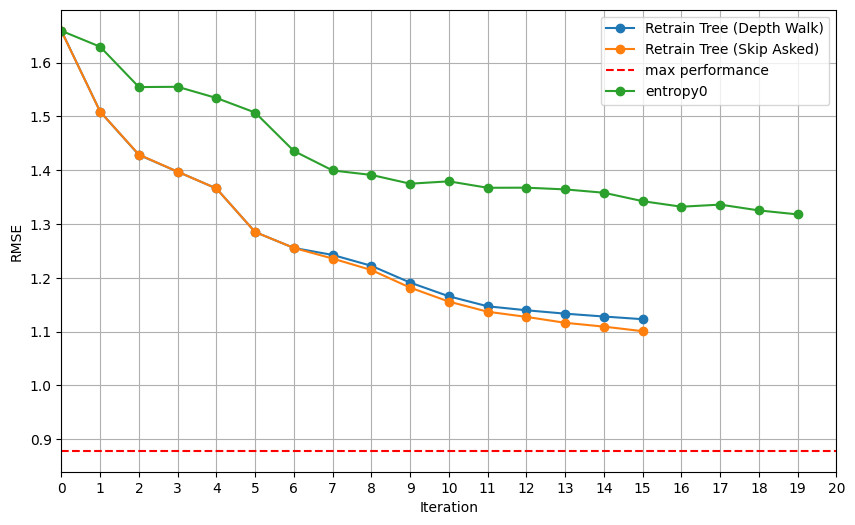

In [25]:
# plot rmse of all methods
plt.figure(figsize=(10, 6))
# fix the x axis to be 0-20
plt.xlim(0, 20)
plt.xticks(range(0, 21))
plt.plot(rmse_approach2, label='Retrain Tree (Depth Walk)', marker='o')
plt.plot(rmse_approach3, label='Retrain Tree (Skip Asked) ', marker='o')
# plt.plot(pct4, label='pct_4', marker='o')
# plot rmse_KX_warm_coldK_coldX as a horizontal line
plt.axhline(y=rmse_KX_warm_coldK_coldX, color='r', linestyle='--', label='max performance')
# plt.axhline(y=rmse_coldK_coldX, color='g', linestyle='--', label='coldK_coldX')
plt.plot(rmse_entropy0, label='entropy0', marker='o')

# plt.title('RMSE of Elicitation Methods with warm cold split')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()

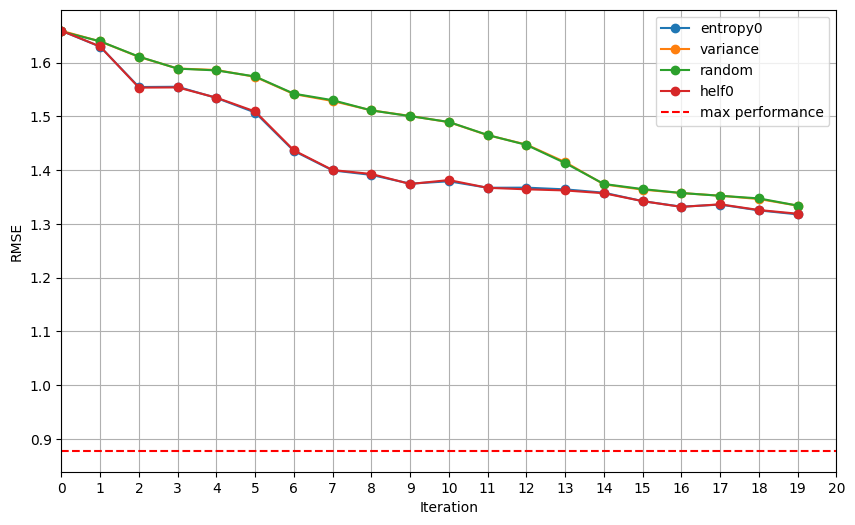

In [26]:
# plot rmse of all methods
plt.figure(figsize=(10, 6))
plt.xlim(0, 20)
plt.xticks(range(0, 21))
plt.plot(rmse_entropy0, label='entropy0', marker='o')
plt.plot(rmse_variance, label='variance', marker='o')
plt.plot(rmse_random, label='random', marker='o')
plt.plot(rmse_helf0, label='helf0', marker='o')
plt.axhline(y=rmse_KX_warm_coldK_coldX, color='r', linestyle='--', label='max performance')
# plt.axhline(y=rmse_coldK_coldX, color='g', linestyle='--', label='coldK_coldX')
# plt.title('RMSE of Nonpersonalized Elicitation Methods with warm cold split')
plt.xlabel('Iteration')
plt.ylabel('RMSE')
plt.legend()
plt.grid()
plt.show()
# plot mae of all methods